In [ ]:
pip install -q transformers datasets

     |████████████████████████████████| 4.7 MB 37.2 MB/s 
     |████████████████████████████████| 365 kB 67.9 MB/s 
     |████████████████████████████████| 120 kB 68.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 
     |████████████████████████████████| 115 kB 72.2 MB/s 
     |████████████████████████████████| 212 kB 76.1 MB/s 
     |████████████████████████████████| 127 kB 65.0 MB/s 


## Load data set, Euroset data set open on kaggle

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_files='https://madm.dfki.de/files/sentinel/EuroSAT.zip')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-0537267e6f812d56/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

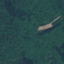

In [ ]:
example= dataset['train'][0]
example['image']

In [ ]:
example['label']

1

In [ ]:
dataset['train'].features['label'].names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
labels=dataset['train'].features['label'].names

In [ ]:
#lets map labels

In [ ]:
id2label={k:v for k,v in enumerate(labels)}
label2id={v:k for k,v in enumerate(labels)}
print(id2label)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [ ]:
#lets push dataset to huggingface hub

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
dataset.push_to_hub("Pratha1m/euroSAT-convnext")


  0%|          | 0/27 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:2168: FutureWarning: `identical_ok` has no effect and is deprecated. It will be removed in 0.11.0.
  FutureWarning,


In [ ]:
from datasets import load_dataset

In [ ]:
loaded_dataset = load_dataset('Pratha1m/euroSAT-convnext')

NameError: ignored

## Process data


In [ ]:
from transformers import ConvNextFeatureExtractor

In [ ]:
feature_extractor = ConvNextFeatureExtractor('facebook/convnext-tiny-224')

In [ ]:
print(feature_extractor)

ConvNextFeatureExtractor {
  "crop_pct": null,
  "do_normalize": true,
  "do_resize": "facebook/convnext-tiny-224",
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



## Now we aplly data agumnentation from pytorch like imagaug,albumentation

In [ ]:
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor   
)

In [ ]:

normalize= Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose(
    [RandomResizedCrop(feature_extractor.size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize
]
)
def train_transform(examples):
  examples['pixel_values'] = [transform(image.convert('RGB')) for image in examples['image']]

  return examples


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [ ]:
#this we can do when we store all tha processed data at once 
transform_dataset=dataset.map(train_transform, batched=True)

  0%|          | 0/27 [00:00<?, ?ba/s]

In [ ]:
#this will help to transform the data when we actually need it so its space efficient
processed_dataset= dataset.with_transform(train_transform)

In [ ]:
processed_dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F08CFE6C310>,
 'label': 1,
 'pixel_values': tensor([[[-1.5185, -1.5185, -1.5185,  ..., -1.5185, -1.5185, -1.5185],
          [-1.5185, -1.5185, -1.5185,  ..., -1.5185, -1.5185, -1.5185],
          [-1.5185, -1.5185, -1.5185,  ..., -1.5185, -1.5185, -1.5185],
          ...,
          [-1.2617, -1.2617, -1.2617,  ..., -1.6042, -1.6042, -1.6042],
          [-1.2617, -1.2617, -1.2617,  ..., -1.6042, -1.6042, -1.6042],
          [-1.2617, -1.2617, -1.2617,  ..., -1.6042, -1.6042, -1.6042]],
 
         [[-0.8803, -0.8803, -0.8803,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8277, -0.8277, -0.8277],
          [-0.8803, -0.8803, -0.8803,  ..., -0.8277, -0.8277, -0.8277],
          ...,
          [-0.6176, -0.6176, -0.6176,  ..., -1.0378, -1.0378, -1.0378],
          [-0.6176, -0.6176, -0.6176,  ..., -1.0378, -1.0378, -1.0378],
          [-0.6176, -0.6176, -0.6176,  ..., -1.0378, -1

In [ ]:
len(labels)

10

In [ ]:
#lets load our pretrained model and we used automodel class from huggingface to do so to initiate our model
#we did mismatched data to true bcz model is trained on 1000 labels and we want to train it on 10 labels
#so in order to fine tune the model on custom  data we did mismatch value to true

In [ ]:
from transformers import AutoModelForImageClassification

model =AutoModelForImageClassification.from_pretrained('facebook/convnext-tiny-224',
                                                       num_labels=len(labels),
                                                       id2label=id2label,
                                                       label2id=label2id,
                                                       ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Train The model

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

## In pytorch we have data loader which itrates over the data and passes it to the model

In [ ]:
from torch.utils.data import DataLoader
#we are creating a functio to extract only the pixel value and labels from our
#dataset and conver it to a tensor
def collate_fn(examples):
  pixel_values = torch.stack([example['pixel_values'] for example in examples])
  labels = torch.tensor([example['label'] for example in examples])

  return {'pixel_values':pixel_values,'labels':labels}

dataloader = DataLoader(processed_dataset['train'], collate_fn= collate_fn, batch_size=4, shuffle= True)


In [ ]:
batch = next(iter(dataloader))
for k,v in batch.items():
  print(k,v.shape)


pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


Train the Model

In [ ]:
from tqdm.notebook import tqdm

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(10):
  correct=0
  total=0
  print('Epoch:',epoch)
  for idx, batch in enumerate(dataloader):
    #move to gpu
    batch = {k:v.to(device) for k,v in batch.items()}

    optimizer.zero_grad()

    #forward pass
    outputs = model(pixel_values=batch['pixel_values'],
                    labels=batch['labels'])
    loss= outputs.loss

    loss.backward()
    optimizer.step()

    #print('Loss', loss.item())

    #metrics

    total += batch['labels'].shape[0]
    predicted = outputs.logits.argmax(-1)
    correct+= (predicted == batch['labels']).sum().item()
    accuracy= correct/total
    
    if idx%100 == 0:
      print(f'Loss after {idx} steps:',loss.item())
      print(f"accuracy after {idx} steps:",accuracy)



    



Streaming output truncated to the last 5000 lines.
Loss 0.013821951113641262
Loss 0.7496526837348938
Loss 0.012329146265983582
Loss 0.08785536885261536
Loss 0.0007250459748320282
Loss 0.00046910159289836884
Loss 0.0020486339926719666
Loss 0.7236620783805847
Loss 0.27031004428863525
Loss 0.18420417606830597
Loss 0.0010359409498050809
Loss 0.0010709860362112522
Loss 0.0014374484308063984
Loss 0.8353691101074219
Loss 0.0011433311738073826
Loss 0.0008814290631562471
Loss 0.49100133776664734
Loss 0.0006175010930746794
Loss 0.07788214832544327
Loss 0.011406544595956802
Loss 0.0004314820689614862
Loss 0.0037275366485118866
Loss 0.3937618136405945
Loss 0.0019109148997813463
Loss 0.001629107864573598
Loss 0.5775732398033142
Loss 0.020537491887807846
Loss 0.08702491968870163
Loss 0.0006989794783294201
Loss 0.37350860238075256
Loss 0.006368204951286316
Loss 0.02886349707841873
Loss 1.190907597541809
Loss 0.0009650652064010501
Loss 0.003096909262239933
Loss 0.1313837468624115
Loss 0.00207020738162

# Push it to hub


In [ ]:
repo_name='Prath1m/convnext-finetuned-eurosat'

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

To https://huggingface.co/Pratha1m/convnext-finetuned-eurosat
   66794e6..24a3f59  main -> main

   66794e6..24a3f59  main -> main



'https://huggingface.co/Pratha1m/convnext-finetuned-eurosat/commit/24a3f5941cae5d2c6d301d7641ba913933773533'

##Infrenece


In [ ]:
#to reload the pused model and feature extractor from the hub
from transformers import AutoFeatureExtractor , AutoModelForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("Prath1m/convnext-finetuned-eurosat")
model=AutoModelForImageClassification.from_pretrained("Prath1m/convnext-finetuned-eurosat")

In [ ]:
from PIL import Image
import requests

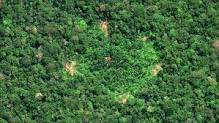

In [ ]:
url= "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSBBXVuTwLYtXRmwr4oIRiiT_ZAQGMmNzO6H0ncESRR&s"
Image = Image.open(requests.get(url,stream=True).raw)
Image

In [ ]:
pixel_values=feature_extractor(Image.convert('RGB'),return_tensors='pt').pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
import torch

with torch.no_grad():
  output=model(pixel_values)
  logits=output.logits

In [ ]:
print(logits.shape)

torch.Size([1, 10])


In [ ]:
predicted_class_idx=logits.argmax(-1).item()
print(model.config.id2label[predicted_class_idx])

Forest
